# Application of Deep Learning : Mask wearing detection with OpenCV, Keras / TensorFlow
*Code by :*
- Nur Izzati BINTI ABD HARIS
- Nadwah Azizah BINTI MOHD KAMAL AZHARI 

**Web break our project into two distinct phases, each with its own respective sub-steps :** 
- ***Phase 1 : Training*** : Here we’ll focus on loading our face mask detection dataset from disk, training a model (using Keras/TensorFlow) on this dataset, and then serializing the face mask detector to disk 

- ***Phase 2 : Deployment*** : Once the face mask detector is trained, we can then move on to loading the mask detector, performing face detection, and then classifying each face as No_mask or Face_mask

# Phase 1 : Training Face Mask Detector

## 1. Preparation of data set for training

In [1]:
# Includes all library installed using pip
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#try to read one image from Dataset
img_array = cv2.imread("Dataset/Face_Mask/00000_Mask.jpg") 

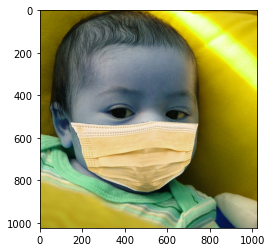

In [3]:
#By default, the image is in BGR, the color shown is not the real color
plt.imshow(img_array) #BGR

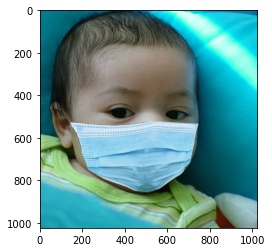

In [4]:
#Convert BGR to RGB
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)) #RGB

In [5]:
img_array.shape #show result => (size,size,channel) channel : 3 [R,G,B]

(1024, 1024, 3)

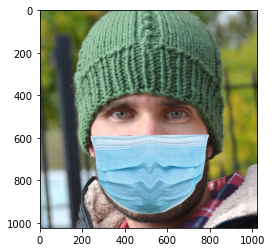

In [6]:
Datadirectory = "Dataset/" #training dataset
Classes = ["Face_Mask","No_Mask"] #list classes
for category in Classes :
    path = os.path.join(Datadirectory, category) # concatenate folder name to form paths
    for img in os.listdir(path): #read all the files listed in this path
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break    # for testing purpose, we break after read one picture to see the result
    break

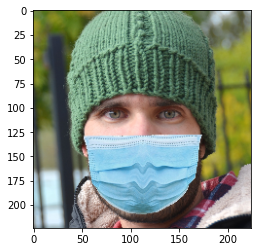

In [7]:
img_size = 224 # ImageNet need size => 224 x 224
new_array = cv2.resize(img_array,(img_size,img_size)) # convert size from 1024 to 224
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show()

### - reading the images and converting it to array

In [8]:
#We need Data and Target Label: 

training_Data = [] #Data
def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory,category)
        class_num = Classes.index(category) #Target Label
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (img_size, img_size)) #make sure the size always 224 x 224
                training_Data.append([new_array,class_num]) #saving dataset and classLabel by appending list 
            except Exception as e:
                pass

In [9]:
create_training_Data()

In [16]:
print(len(training_Data)) #See how many images stored? (face mask + no mask)

1772


In [10]:
import random 
random.shuffle(training_Data) # we shuffle the training data so that deeplearning don't learn the sequence

In [11]:
X = [] #data /feature
y = [] #will store label 0 and 1 (0 -> facemask or 1->no mask)

for features,label in training_Data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, img_size, img_size, 3)

In [12]:
X.shape

(1772, 224, 224, 3)

In [13]:
#normalize the data
X = X/255.0;

In [14]:
Y = np.array(y)

### - store all data in pickle
**(Pickle in Python is primarily used in serializing and deserializing a Python object structure)**

In [17]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [18]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

## 2. Deep Learning model for training - Transfer learning
### Accepts our input dataset and fine-tunes MobileNet upon it to create our mask detector model

In [19]:
from tensorflow import keras
from tensorflow.keras import layers 

In [20]:
#choose MobileNet because it's lightweight
model = tf.keras.applications.mobilenet.MobileNet() #it's already a pre-trained model

In [21]:
model.summary() #look the layers in the model

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### - Transfer learning

In [22]:
base_input = model.layers[0].input #the first layer as input
base_output = model.layers[-4].output # the last four layers as output

In [23]:
#concatenate three more layers
Flat_layer = layers.Flatten()(base_output)
final_output = layers.Dense(1)(Flat_layer) #binary classifier [0,1]. [have face mask or not]
final_ouput = layers.Activation('sigmoid')(final_output)

In [24]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [25]:
new_model.summary() # we can see that the total params is reduced compared to last time

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

### - setting for binary classification ( Face Mask / No Mask )

In [26]:
new_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [29]:
#training. execute few times to get Val_accuracy>95%
new_model.fit(X, Y, epochs = 1, validation_split = 0.1)

50/50 [==============================] - 146s 3s/step - loss: 0.1282 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [30]:
new_model.save('mask_detector_model.h5') #save our model for future use